In [ ]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [ ]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [ ]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)


cpu


# Model definition

In [ ]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, validation, test = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [ ]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.net = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.net[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.net[-1](x)

# test model
model = HarmonicModel(
    n_in=4,
    hidden_sizes=[64, 32, 16],   # ← arbitrary shapes
    activation='tanh'
).to(device)

In [ ]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

In [ ]:
#train model
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)
    
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model #return trained model, not final loss

#evaluate model
def evaluate_harmonic(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    t = X_val[:, :, 3]
    k = X_val[:, :, 0]
    x_00 = X_val[:, :, 1]
    x_01 = X_val[:, :, 2]

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val, x_00, x_01, t, k, N_f=1000)

    return loss.item()

# Hyperparameter optimization

## 1) Using random hyperparameter search

In [ ]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, lr_i: tuple, train_data, val_data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive

        hidden_sizes = [
            random.randint(neurons_i[0], neurons_i[1])
            for _ in range(n_layers)
        ]

        activation = random.choice(activations_l)

        lr = 10 ** random.uniform(
            torch.log10(torch.tensor(lr_i[0])).item(),
            torch.log10(torch.tensor(lr_i[1])).item()
        )

        params = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'lr': lr
        }

        model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)
        #train_model
        train_harmonic(model, lr=lr, epochs=100, data=train_data)

        #evaluate on validation data
        val_loss = evaluate_harmonic(model,data=val_data)

        result.append((params, val_loss))
    
    return result

In [ ]:
n_trials = 50
results_opt_rand = rng_hparameters_search(n_trials,
                                 layers_i=(2, 5),
                                 neurons_i=(16, 128),
                                 activations_l=['tanh', 'sine', 'gelu', 'relu'],
                                 lr_i= (1e-4, 1e-2),
                                 train_data = train,
                                 val_data = validation, 
                                 device=device,
                                 seed=0)

Hyperparameter search:  33%|███▎      | 1/3 [00:13<00:27, 13.75s/it]

Epoch 100/100, Loss: 0.4193


Hyperparameter search:  67%|██████▋   | 2/3 [00:28<00:14, 14.18s/it]

Epoch 100/100, Loss: 0.6146


Hyperparameter search: 100%|██████████| 3/3 [00:41<00:00, 13.76s/it]

Epoch 100/100, Loss: 0.1388


## 2) Using Bayesian hyperparameter search

In [ ]:
# Define your hyperparameter ranges and data
layers_i = (2, 5)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
lr_i = (1e-4, 1e-2)
train_data = train
val_data   = validation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, lr_i, train_data, val_data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    hidden_sizes = [trial.suggest_int(f"neurons_l{i}", neurons_i[0], neurons_i[1]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", activations_l)
    lr = trial.suggest_float("lr", lr_i[0], lr_i[1], log=True)


    model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)

    #train model
    train_harmonic(model, lr=lr, epochs=100, data=train_data)

    #evaluate model
    val_loss = evaluate_harmonic(model, data=val_data)

    return val_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective,
                                    layers_i=layers_i,
                                    neurons_i=neurons_i,
                                    activations_l=activations_l,
                                    lr_i=lr_i,
                                    train_data=train_data,
                                    val_data=val_data
                                    )

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-12-04 10:07:37,887] A new study created in memory with name: no-name-0185730b-255f-4a7d-ba7d-8490c8b79581
[I 2025-12-04 10:07:52,928] Trial 0 finished with value: 0.6702682375907898 and parameters: {'n_layers': 3, 'neurons_l0': 91, 'neurons_l1': 110, 'neurons_l2': 105, 'activation': 'tanh', 'lr': 0.0004997386397437456}. Best is trial 0 with value: 0.6702682375907898.


Epoch 100/100, Loss: 0.6476


[I 2025-12-04 10:07:58,315] Trial 1 finished with value: 0.33265769481658936 and parameters: {'n_layers': 2, 'neurons_l0': 58, 'neurons_l1': 49, 'activation': 'sine', 'lr': 0.0059706518726038915}. Best is trial 1 with value: 0.33265769481658936.


Epoch 100/100, Loss: 0.3327


[I 2025-12-04 10:08:06,503] Trial 2 finished with value: 0.647257924079895 and parameters: {'n_layers': 4, 'neurons_l0': 19, 'neurons_l1': 53, 'neurons_l2': 110, 'neurons_l3': 24, 'activation': 'tanh', 'lr': 0.001097645417356553}. Best is trial 1 with value: 0.33265769481658936.


Epoch 100/100, Loss: 0.6245


In [ ]:
print("Best params:", study.best_params)
print("Best loss:", study.best_value)

Best params: {'n_layers': 2, 'neurons_l0': 58, 'neurons_l1': 49, 'activation': 'sine', 'lr': 0.0059706518726038915}
Best loss: 0.33265769481658936


In [ ]:
#for random search
best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'hidden_sizes': [95, 118], 'activation': 'gelu', 'lr': 0.009430145683311597}
Final loss: 1.322e-01


# Test best hyperparameters

In [ ]:
hidden_sizes_opt_rand = best_params["hidden_sizes"]
activation_opt_rand = best_params["activation"]
lr_opt_rand = best_params["lr"]

hidden_sizes_opt_bayes = [study.best_params[k] for k in sorted(study.best_params) if k.startswith('neurons_l')]
activation_opt_bayes = study.best_params["activation"]
lr_opt_bayes = study.best_params["lr"]

model_optimized_rand = HarmonicModel(n_in=4,
                                     hidden_sizes=hidden_sizes_opt_rand,
                                     activation=activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(n_in=4,
                                      hidden_sizes=hidden_sizes_opt_bayes,
                                      activation=activation_opt_bayes).to(device)

In [ ]:
# training
train_harmonic(model_optimized_rand, lr=lr_opt_rand, epochs=1000, data=train)
train_harmonic(model_optimized_bayes, lr=lr_opt_bayes, epochs=1000, data=train)

Epoch 1000/1000, Loss: 0.0112
Epoch 1000/1000, Loss: 0.0021


HarmonicModel(
  (net): ModuleList(
    (0): Linear(in_features=4, out_features=58, bias=True)
    (1): Linear(in_features=58, out_features=49, bias=True)
    (2): Linear(in_features=49, out_features=1, bias=True)
  )
)

In [ ]:
#evaluate
loss_opt_rand = evaluate_harmonic(model_optimized_rand, data=val_data)
loss_opt_bayes = evaluate_harmonic(model_optimized_bayes, data=val_data)

if loss_opt_rand < loss_opt_bayes:
    best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
else:
    best_params = study.best_params
    best_params = {
    'n_layers': best_params['n_layers'],
    'hidden_sizes': hidden_sizes_opt_bayes,
    'activation': best_params['activation'],
    'lr': best_params['lr']
}

print(f"The validation loss on the Random optimization is {loss_opt_rand}")
print(f"The validation loss on the Bayesian optimization is {loss_opt_bayes}")

The validation loss on the Random optimization is 0.003387670498341322
The validation loss on the Bayesian optimization is 0.0018209087429568172


In [ ]:
# test dataset random
test_loss_rand = evaluate_harmonic(model_optimized_rand, data=test)
print(f"Test Loss Random optimization: {test_loss_rand:.4f}")

# test dataset bayes
test_loss_bayes = evaluate_harmonic(model_optimized_bayes, data=test)
print(f"Test Loss Random optimization: {test_loss_bayes:.4f}")

Test Loss Random optimization: 0.0051
Test Loss Random optimization: 0.0046


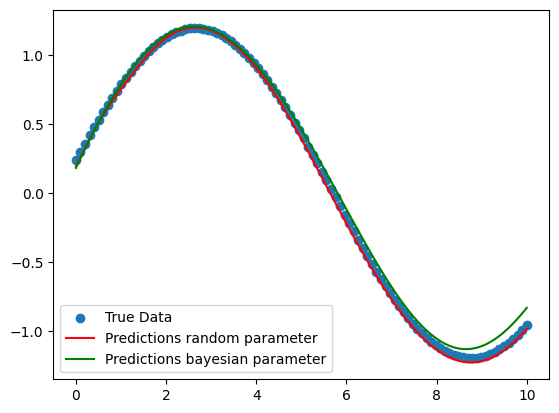

In [ ]:
#Look at performance on test data
X = test["X"]

y_pred_rand = model_optimized_rand(X).squeeze(-1)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)

n = 110 #defines which initial conditions we look at?
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

# K-fold 

In [ ]:
#put train and validation together so K-fold can do its work
data = {
    'args_tensor': torch.cat([train['args_tensor'], validation['args_tensor']], dim=0),
    'x0_tensor':   torch.cat([train['x0_tensor'],   validation['x0_tensor']],   dim=0),
    't_tensor':    torch.cat([train['t_tensor'],    validation['t_tensor']],    dim=0),
    'y_tensor':    torch.cat([train['y_tensor'],    validation['y_tensor']],    dim=0),
    'X':           torch.cat([train['X'],           validation['X']],           dim=0),
}

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(n_in=4,
                          hidden_sizes=best_params['hidden_sizes'],
                          activation=best_params['activation']).to(device)

    # Train model on this fold
    train_harmonic(model, lr=best_params['lr'], epochs=100, data=train_fold)
    loss_val = evaluate_harmonic(model, val_data=val_fold)
    fold_losses.append(loss_val)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


{'n_layers': 2, 'hidden_sizes': [58, 49], 'activation': 'sine', 'lr': 0.0059706518726038915}
Epoch 100/100, Loss: 0.3091
Epoch 100/100, Loss: 0.3258
Epoch 100/100, Loss: 0.4186
Epoch 100/100, Loss: 0.3021
Epoch 100/100, Loss: 0.1535
Estimated generalization loss (K-Fold CV): 0.29984534084796904


# Test the model on noisy data

In [ ]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset


In [ ]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_bayes_noise = model_optimized_bayes(X).squeeze(-1)


test_loss_bayes_noise = evaluate_harmonic(model_optimized_bayes, data=test_noise)
print(f"Test Loss Random optimization: {test_loss_bayes_noise:.4f}")

Test Loss Random optimization: 0.1958


/tmp/ipykernel_6603/1528747743.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


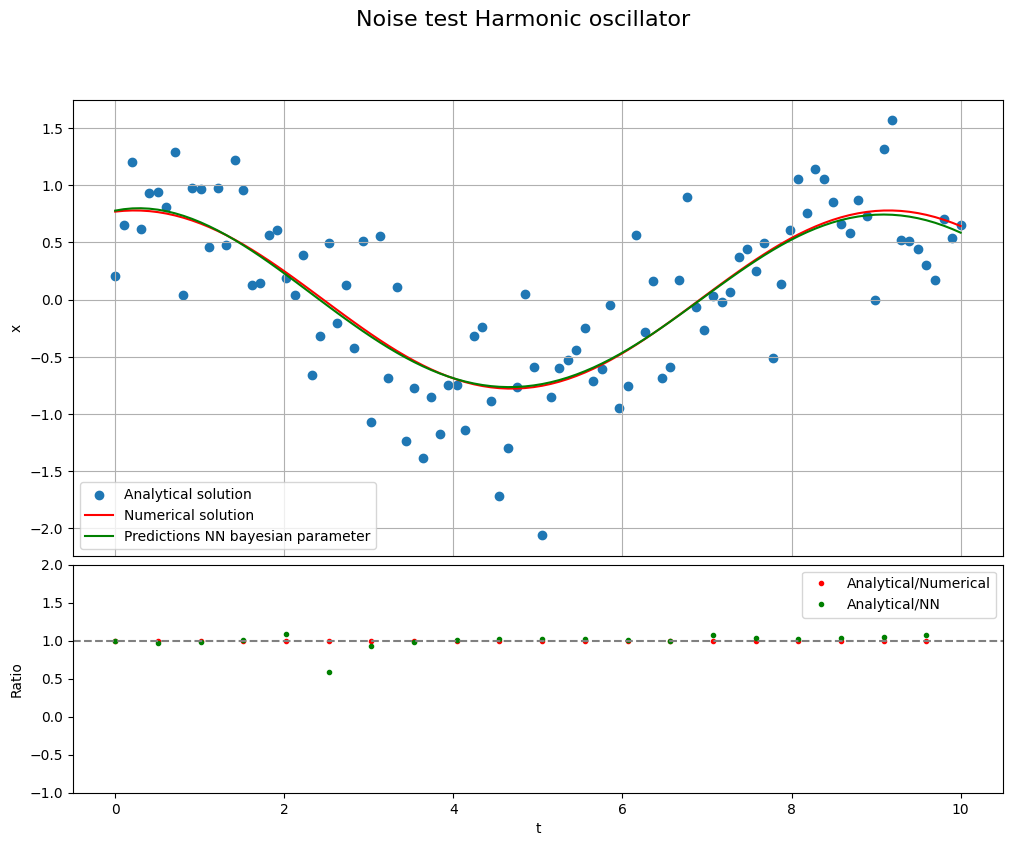

In [ ]:
n = 0

y_pred_bayes_noise.to("cpu")
test_noise["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_bayes_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_bayes_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

# Test generalization

In [ ]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_bayes_generalization = model_optimized_bayes(X).squeeze(-1)


test_loss_bayes_generalization = evaluate_harmonic(model_optimized_bayes, data=test_generalization)
print(f"Test Loss Random optimization: {test_loss_bayes_generalization:.4f}")

Test Loss Random optimization: 9.6685


/tmp/ipykernel_6603/3597319278.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


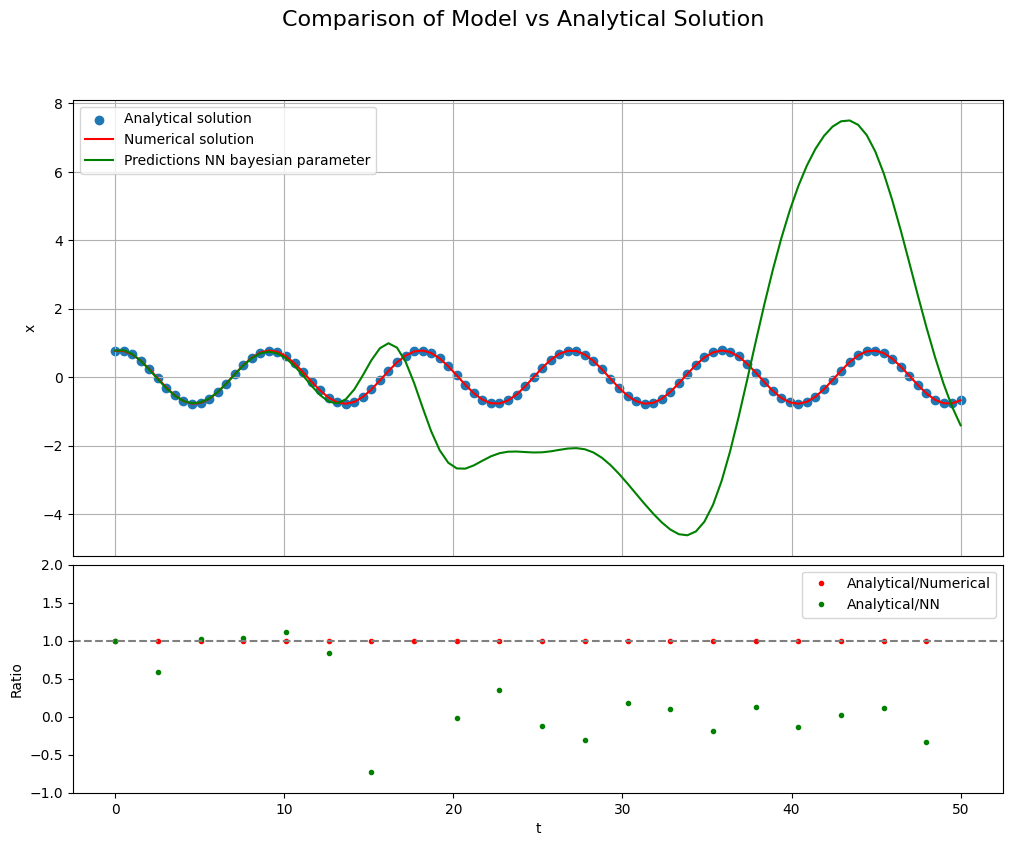

In [ ]:
n = 0

y_pred_bayes_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_bayes_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_bayes_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

# Test physical quantities

### Energy conservation

Initial energy E0 = 1.498863e-01
Max absolute deviation = 1.380862e+01
Max relative deviation = 9.212729e+01


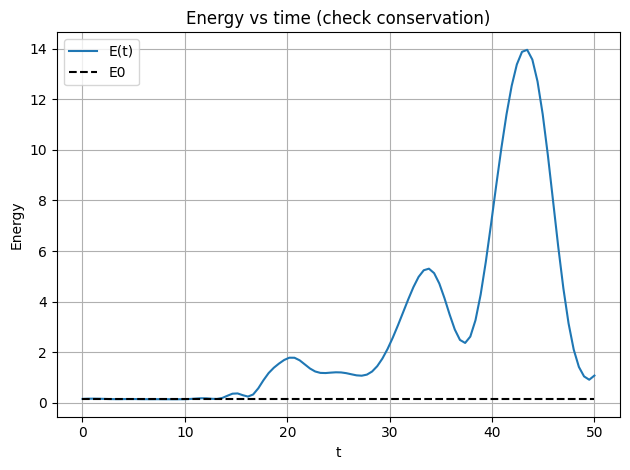

In [ ]:
n = 0  # choose trajectory index

# Position
x = y_pred_bayes_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test physical quantities

# TO DO

- Test physical quantities of model
- Make sure both models are comparable
- Compare both models